In [1]:
# %load_ext autoreload
%reload_ext autoreload
%autoreload 2

import os
import random
import time
from concurrent.futures import ThreadPoolExecutor
from io import BytesIO
from pathlib import Path
from zipfile import ZipFile

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2
from clearml import Task
from dotenv import load_dotenv
from torch import nn
from torch.utils.data import DataLoader

from mglyph_ml.dataset.glyph_dataset import GlyphDataset
from mglyph_ml.dataset.manifest import DatasetManifest


In [2]:
task_name = "Experiment 1.2.1"
task_tag = "exp-1.2.1"
dataset_path = Path("data/uni.mglyph")
gap_start_x = 40.0
gap_end_x = 60.0
seed = 420
max_epochs = 1
offline = False
batch_size = 92
data_loader_num_workers = 40
n_of_gap_samples = 3000
n_of_overall_samples = 3000

In [3]:
# Parameters
gap_start_x = 10.0
gap_end_x = 90.0


In [4]:
Task.set_offline(offline)
task: Task = Task.init(project_name="mglyph-ml", task_name=task_name)
task.add_tags(task_tag)
logger = Task.current_task().logger
load_dotenv()

task.connect({
    "dataset_path": str(dataset_path),
    "gap_start_x": gap_start_x,
    "gap_end_x": gap_end_x,
    "seed": seed,
    "max_epochs": max_epochs,
    "batch_size": batch_size,
    "data_loader_num_workers": data_loader_num_workers,
    "n_of_gap_samples": n_of_gap_samples,
    "n_of_overall_samples": n_of_overall_samples,
})

Failed accessing the jupyter server(s): []


ClearML Task: overwriting (reusing) task id=9874f7edd40c4e60860a4b45d3478dd1


ClearML results page: https://app.clear.ml/projects/07b4a6419a394b41958e58d40935de55/experiments/9874f7edd40c4e60860a4b45d3478dd1/output/log


{'dataset_path': 'data/uni.mglyph',
 'gap_start_x': 10.0,
 'gap_end_x': 90.0,
 'seed': 420,
 'max_epochs': 1,
 'batch_size': 92,
 'data_loader_num_workers': 40,
 'n_of_gap_samples': 3000,
 'n_of_overall_samples': 3000}

In [5]:
# loading everything... this cell takes the longest time
# Load the entire zip file into memory
with open(dataset_path, "rb") as f:
    temp_archive = ZipFile(BytesIO(f.read()))

manifest_data = temp_archive.read("manifest.json")
manifest = DatasetManifest.model_validate_json(manifest_data)

samples_0 = manifest.samples["0"]  # this is where the training and validation data comes from
samples_1 = manifest.samples["1"]  # this is where the test data comes from

print(f"samples_0 count: {len(samples_0)}")
print(f"samples_1 count: {len(samples_1)}")

# Create index mappings for each subset
_eval_rng = random.Random(seed)

indices_train = [i for i, sample in enumerate(samples_0) if sample.x < gap_start_x or sample.x >= gap_end_x]

indices_gap = [i for i, sample in enumerate(samples_0) if sample.x >= gap_start_x and sample.x < gap_end_x]
n_gap_actual = min(n_of_gap_samples, len(indices_gap))
indices_gap = _eval_rng.sample(indices_gap, n_gap_actual)
indices_gap.sort()

all_indices_1 = list(range(len(samples_1)))
n_overall_actual = min(n_of_overall_samples, len(all_indices_1))
indices_overall = _eval_rng.sample(all_indices_1, n_overall_actual)
indices_overall.sort()

# Load all images from memory using OpenCV (faster than PIL, directly to numpy)
def load_image_cv2(sample):
    img_bytes = temp_archive.read(sample.filename)
    img_array = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
    # OpenCV loads in BGR, convert to RGB
    return img_array

with ThreadPoolExecutor(max_workers=32) as executor:
    images_0 = list(executor.map(load_image_cv2, samples_0))
    images_1 = list(executor.map(load_image_cv2, samples_1))

temp_archive.close()

print(f"gap eval samples:     {len(indices_gap)}")
print(f"overall eval samples: {len(indices_overall)}")

# Reference image subsets using indices
images_train = [images_0[i] for i in indices_train]
images_gap = [images_0[i] for i in indices_gap]
images_overall = [images_0[i] for i in indices_overall]

labels_train = [samples_0[i].x for i in indices_train]
labels_gap = [samples_0[i].x for i in indices_gap]
labels_overall = [samples_0[i].x for i in indices_overall]

samples_0 count: 20000
samples_1 count: 20000


gap eval samples:     3000
overall eval samples: 3000


In [6]:
# dataset creation
affine = A.Affine(
    rotate=(-3, 3),
    translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)},
    fit_output=False,
    keep_ratio=True,
    border_mode=cv2.BORDER_CONSTANT,
    fill=255,
    p=1.0,
)
normalize = A.Normalize(mean=0.0, std=1.0, max_pixel_value=255.0)
to_tensor = ToTensorV2()
pipeline = A.Compose([affine, normalize, to_tensor], seed=seed)
normalize_pipeline = A.Compose([normalize, to_tensor])


def affine_and_normalize(image: np.ndarray) -> torch.Tensor:
    return pipeline(image=image)["image"]


def just_normalize(image: np.ndarray) -> torch.Tensor:
    return normalize_pipeline(image=image)["image"]


dataset_train = GlyphDataset(images=images_train, labels=labels_train, transform=affine_and_normalize)
dataset_gap = GlyphDataset(images=images_gap, labels=labels_gap, transform=just_normalize)
dataset_overall = GlyphDataset(images=images_overall, labels=labels_overall, transform=just_normalize)

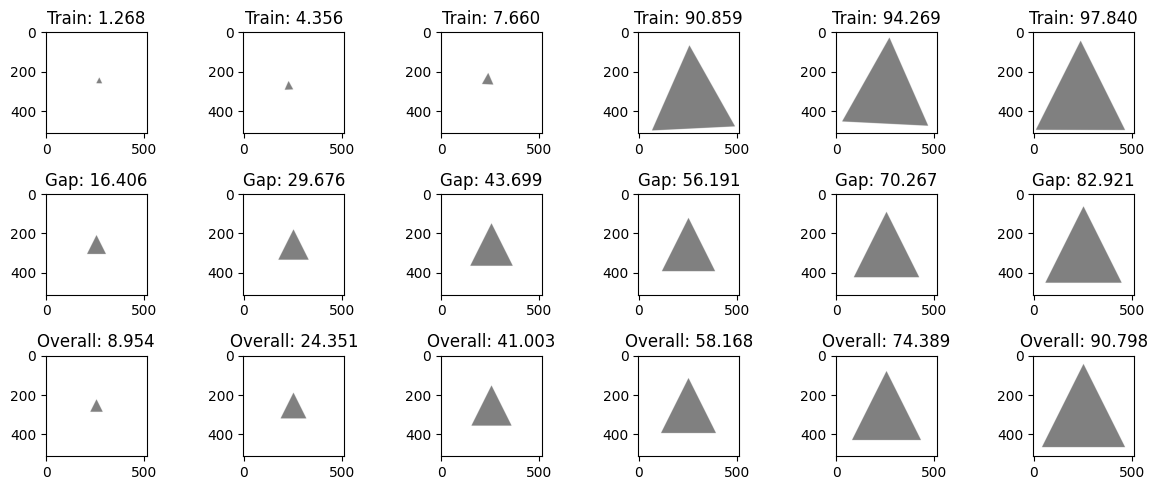

In [7]:
# Display sample images from datasets

x_samples = 6

fig, axes = plt.subplots(3, x_samples, figsize=(2 * x_samples, 5))

# training images
for i in range(x_samples):
    idx = i * len(dataset_train) // x_samples + len(dataset_gap) // x_samples // 2
    img_tensor, label = dataset_train[idx]
    img = img_tensor.permute(1, 2, 0).numpy()
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Train: {label * 100.0:.3f}")

# gap images
for i in range(x_samples):
    idx = i * len(dataset_gap) // x_samples + len(dataset_gap) // x_samples // 2
    img_tensor, label = dataset_gap[idx]
    img = img_tensor.permute(1, 2, 0).numpy()
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Gap: {label * 100.0:.3f}")

# test images
for i in range(x_samples):
    idx = i * len(dataset_overall) // x_samples + len(dataset_overall) // x_samples // 2
    img_tensor, label = dataset_overall[idx]
    img = img_tensor.permute(1, 2, 0).numpy()
    axes[2, i].imshow(img)
    axes[2, i].set_title(f"Overall: {label * 100.0:.3f}")

plt.tight_layout()
plt.show()

In [8]:
from mglyph_ml.nn.glyph_regressor_gen2 import GlyphRegressor

device = os.environ["MGML_DEVICE"]
print(f"Training device: {device}")
model = GlyphRegressor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model = model.to(device)
generator = torch.Generator().manual_seed(seed)

data_loader_train = DataLoader(
    dataset_train,
    batch_size=batch_size,
    num_workers=data_loader_num_workers,
    pin_memory=True,
    shuffle=True,
    generator=generator,
)
data_loader_gap = DataLoader(
    dataset_gap,
    batch_size=batch_size,
    num_workers=data_loader_num_workers,
    pin_memory=True,
    shuffle=True,
    generator=generator,
)
data_loader_overall = DataLoader(
    dataset_overall,
    batch_size=batch_size,
    num_workers=data_loader_num_workers,
    pin_memory=True,
    shuffle=True,
    generator=generator,
)

for epoch in range(1, max_epochs + 1):
    model.train()
    epoch_start_time = time.time()
    running_train_loss = 0.0
    running_error_train = 0.0
    num_batches_train = 0

    for index, data in enumerate(data_loader_train):
        inputs, labels = data
        inputs: torch.Tensor = inputs.to(device)
        labels: torch.Tensor = labels.to(device)

        inputs = inputs.float()
        labels = labels.float().view(-1, 1)

        optimizer.zero_grad()
        outputs: torch.Tensor = model(inputs)
        loss = criterion(outputs.float(), labels.float())
        loss.backward()
        optimizer.step()

        # Calculate accuracy as the average absolute difference (y_hat - y)
        error = torch.mean(torch.abs(outputs.float() - labels.float())).item()

        running_train_loss += loss.item()
        running_error_train += error
        num_batches_train += 1

        # print(f"Batch {epoch}:{index} finito with error {error}")

    # Calculate average training metrics
    avg_train_loss = running_train_loss / num_batches_train
    avg_train_error = running_error_train / num_batches_train  # MAE in normalized space (0-1)
    avg_train_error_x = avg_train_error * 100.0  # MAE in x space (0-100)

    # Set model to evaluation mode
    model.eval()

    # Gap evaluation (x in [gap_start_x, gap_end_x))
    running_loss_gap = 0.0
    running_error_gap = 0.0
    num_batches_gap = 0

    with torch.no_grad():
        for inputs, labels in data_loader_gap:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            error = torch.mean(torch.abs(outputs - labels)).item()

            running_loss_gap += loss.item()
            running_error_gap += error
            num_batches_gap += 1

    avg_gap_loss = running_loss_gap / num_batches_gap
    avg_gap_error = running_error_gap / num_batches_gap  # MAE in normalized space (0-1)
    avg_gap_error_x = avg_gap_error * 100.0  # MAE in x space (0-100)

    # Overall evaluation (full 0-100 range)
    running_loss_overall = 0.0
    running_error_overall = 0.0
    num_batches_overall = 0

    with torch.no_grad():
        for inputs, labels in data_loader_overall:
            inputs = inputs.to(device)
            labels = labels.to(device)
            labels = labels.view(-1, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            error = torch.mean(torch.abs(outputs - labels)).item()

            running_loss_overall += loss.item()
            running_error_overall += error
            num_batches_overall += 1

    avg_overall_loss = running_loss_overall / num_batches_overall
    avg_overall_error = running_error_overall / num_batches_overall  # MAE in normalized space (0-1)
    avg_overall_error_x = avg_overall_error * 100.0  # MAE in x space (0-100)

    epoch_time = time.time() - epoch_start_time

    # Log metrics to ClearML
    logger.report_scalar(title="Loss", series="Train", value=avg_train_loss, iteration=epoch)
    logger.report_scalar(title="Loss", series="Gap", value=avg_gap_loss, iteration=epoch)
    logger.report_scalar(title="Loss", series="Overall", value=avg_overall_loss, iteration=epoch)

    logger.report_scalar(title="MAE (normalized)", series="Train", value=avg_train_error, iteration=epoch)
    logger.report_scalar(title="MAE (normalized)", series="Gap", value=avg_gap_error, iteration=epoch)
    logger.report_scalar(title="MAE (normalized)", series="Overall", value=avg_overall_error, iteration=epoch)

    logger.report_scalar(title="MAE (x-space)", series="Train", value=avg_train_error_x, iteration=epoch)
    logger.report_scalar(title="MAE (x-space)", series="Gap", value=avg_gap_error_x, iteration=epoch)
    logger.report_scalar(title="MAE (x-space)", series="Overall", value=avg_overall_error_x, iteration=epoch)

    logger.report_scalar(title="Timing", series="Epoch Duration (s)", value=epoch_time, iteration=epoch)

    # Print epoch summary
    print(f"=" * 80)
    print(f"Epoch {epoch}/{max_epochs}")
    print(f"-" * 80)
    print(f"  Train Loss:      {avg_train_loss:.6f}  |  Train MAE (x):   {avg_train_error_x:.4f}")
    print(f"  Gap Loss:        {avg_gap_loss:.6f}  |  Gap MAE (x):     {avg_gap_error_x:.4f}")
    print(f"  Overall Loss:    {avg_overall_loss:.6f}  |  Overall MAE (x): {avg_overall_error_x:.4f}")
    print(f"  Epoch Time:      {epoch_time:.2f}s")
    print(f"=" * 80)


Training device: cuda:2


Epoch 1/1
--------------------------------------------------------------------------------
  Train Loss:      0.537375  |  Train MAE (x):   50.4202
  Gap Loss:        0.013806  |  Gap MAE (x):     8.9673
  Overall Loss:    0.022074  |  Overall MAE (x): 11.2062
  Epoch Time:      76.87s
